# Decision Tree Model

In [42]:
# decision tree model
import math
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


In [43]:
# Auxiliar functions

def entropy_func(c, n):
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    if c1== 0 or c2 == 0:  
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

def entropy_of_one_division(division): 
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

def get_entropy(y_predict, y_real):
    """
    Getting the whole entropy
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

class OurDecisionTreeClassifier(object):
    """ Decision Tree model using numpy """

    def __init__(self, max_depth=5):
        """
        Model constructor
        Inputs:
        max_depth -> maximum depth of the classifier tree
        """
        self.depth = 0
        self.max_depth = max_depth

    def get_params(self, deep=True):
        """
        Get the model hyperparameters
        """
        return {"max_depth": self.max_depth}
    
    def set_params(self, **params):
        """
        Set de model hyperparameters
        """
        for parameter, value in params.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, x, y, par_node={}, depth=0):
        """
        Training function that generates the tree progressively by using the
        entropy
        """
        if par_node is None: 
            return None
        elif len(y) == 0:
            return None
        elif self.all_same(y):
            return {'val':y[0]}
        elif depth >= self.max_depth:
            return None
        else: 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)    # find one split given an information gain 
            y_left = y[x[:, col] < cutoff]
            y_right = y[x[:, col] >= cutoff]
            par_node = {'col': features[col], 'index_col':col,
                        'cutoff':cutoff,
                       'val': np.round(np.mean(y))}
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.trees = par_node
            return par_node
    
    #all features versus values, get best
    def find_best_split_of_all(self, x, y):
        """
        Get the best values that can split the dataset with 
        the lower entropoy possible
        """
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x.T):
            entropy, cur_cutoff = self.find_best_split(c, y)
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy
    
    def find_best_split(self, col, y):
        """
        Calculate the entropy of only one feature
        """
        min_entropy = 10
        n = len(y)
        for value in set(col):
            y_predict = col < value #get which ones are less than
            my_entropy = get_entropy(y_predict, y)
            if my_entropy <= min_entropy:
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff
    
    def all_same(self, items):
        return all(x == items[0] for x in items)
                                           
    def predict(self, x):
        """
        Predict the category of a series of values
        """
        tree = self.trees
        results = np.array([0]*len(x))
        for i, c in enumerate(x):
            results[i] = self._get_prediction(c)
        return results
    
    def _get_prediction(self, row):
        cur_layer = self.trees
        try:
            while cur_layer.get('cutoff'):
                if row[cur_layer['index_col']] < cur_layer['cutoff']:
                    cur_layer = cur_layer['left']
                else:
                    cur_layer = cur_layer['right']
            else:
                return cur_layer.get('val')
        except:
            return 0.0
    
    def score(self, X, y):
        """
        Score the values obtained
        """
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy
    
    # model metrics
        
    def accurancy(self, y_pred, y_test):
        return accuracy_score(y_test, y_pred)
    
    def precision(self, y_pred,y_test):
        return precision_score(y_test, y_pred)
    
    def recall(self, y_pred,y_test):
        return recall_score(y_test, y_pred)
    
    def auc(self, y_pred,y_test):
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc
    
    def plot_roc(self, fpr, tpr, title):
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('1-Especificity')
        plt.ylabel('Sensibility')
        plt.title(title)
        plt.show()

## Load Cancer dataset


In [44]:
# read the data set
df_wine = pd.read_csv('datasets/winequality-red.csv')

# make sure that there are no null values that can affect the models
mask = df_wine.isnull()
#print(mask.sum())

# visualizing the values of each feature and the comparison to the output
# (not ploting to avoid data overload in the notebook)
"""
for col in df_wine.columns[:-1]:
    df_wine.plot(x=col, y='quality', kind='scatter', figsize=(8, 5))
plt.show()
"""

# Data preprocessing - outliner treatment
# eliminating data that is outside the normal values in each feature
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
l_limit_perc = 0.01
h_limit_perc = 0.99

for feature in features:
    low_limit = df_wine[feature].quantile(l_limit_perc)
    high_limit = df_wine[feature].quantile(h_limit_perc)
    df_wine = df_wine.loc[(df_wine[feature] >= low_limit) & (df_wine[feature] <= high_limit)]

# visualizing the new values
# (not ploting to avoid data overload in the notebook)
"""
for col in df_wine.columns[:-1]:
    df_wine.plot(x=col, y='quality', kind='scatter', figsize=(8, 5))
plt.show()
"""

# feature engineering
# normalization of the data
for feature in features:
    df_wine[feature] = (df_wine[feature]-df_wine[feature].mean())/df_wine[feature].std()

# change the value of the output to only two values
# 0 -> bad wine, wines with 3, 4 and 5 in quality
# 1 -> good wine, wines with 6, 7 and 8 in queality
df_wine.loc[df_wine['quality'] <= 5, 'quality'] = 0
df_wine.loc[df_wine['quality'] > 5, 'quality'] = 1

# Define training and test sets using stratify
X0 = df_wine.loc[df_wine['quality'] == 0, features]
Y0 = df_wine.loc[df_wine['quality'] == 0, 'quality']

X1 = df_wine.loc[df_wine['quality'] == 1, features]
Y1 = df_wine.loc[df_wine['quality'] == 1, 'quality']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, Y0, test_size=0.4, random_state=40)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.4, random_state=40)

X_train = pd.concat([X0_train, X1_train], axis= 0)
y_train = pd.concat([y0_train, y1_train], axis= 0)

df_wine.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.565253,1.059618,-1.411229,-0.553438,-0.287522,-0.479510,-0.355404,0.672341,1.474535,-0.638760,-1.000675,0
1,-0.304938,2.161772,-1.411229,0.207560,0.571559,1.031186,0.767153,0.024570,-0.872713,0.332310,-0.574418,0
2,-0.304938,1.427003,-1.193394,-0.118582,0.337264,-0.047882,0.324934,0.154124,-0.418407,0.089543,-0.574418,0
3,1.907741,-1.512074,1.638460,-0.553438,-0.326572,0.167932,0.529035,0.801895,-1.175584,-0.476915,-0.574418,1
4,-0.565253,1.059618,-1.411229,-0.553438,-0.287522,-0.479510,-0.355404,0.672341,1.474535,-0.638760,-1.000675,0
5,-0.565253,0.814695,-1.411229,-0.662152,-0.326572,-0.263696,-0.151302,0.672341,1.474535,-0.638760,-1.000675,0
6,-0.239859,0.447311,-1.084476,-0.879580,-0.560867,-0.047882,0.495018,-0.234539,-0.115536,-1.447985,-1.000675,0
8,-0.304938,0.324849,-1.302311,-0.444724,-0.404670,-0.695323,-0.899674,0.024570,0.338770,-0.557837,-0.894111,1
9,-0.500174,-0.164997,0.549286,4.012548,-0.482768,0.167932,1.957744,0.672341,0.263052,1.303380,0.171531,0
10,-1.020805,0.324849,-0.975559,-0.662152,0.532510,-0.047882,0.699120,-0.558425,-0.266972,-0.800605,-1.213804,0


    Amount of tests          Model  Accurancy  Precision    Recall       Auc
0                25      Our model   0.620000   0.875000  0.280000  0.620000
1                25  Sklearn model   0.680000   0.680000  0.680000  0.680000
2                63      Our model   0.603175   0.933333  0.222222  0.603175
3                63  Sklearn model   0.674603   0.661765  0.714286  0.674603
4               126      Our model   0.575397   0.913043  0.166667  0.575397
5               126  Sklearn model   0.674603   0.659420  0.722222  0.674603
6               189      Our model   0.574074   0.888889  0.169312  0.574074
7               189  Sklearn model   0.642857   0.632353  0.682540  0.642857
8               226      Our model   0.568584   0.878049  0.159292  0.568584
9               226  Sklearn model   0.654867   0.644628  0.690265  0.654867
10              252      Our model   0.569444   0.872340  0.162698  0.569444
11              252  Sklearn model   0.662698   0.650735  0.702381  0.662698

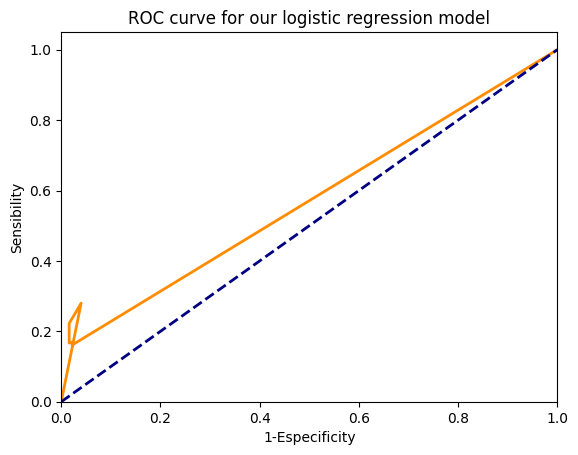

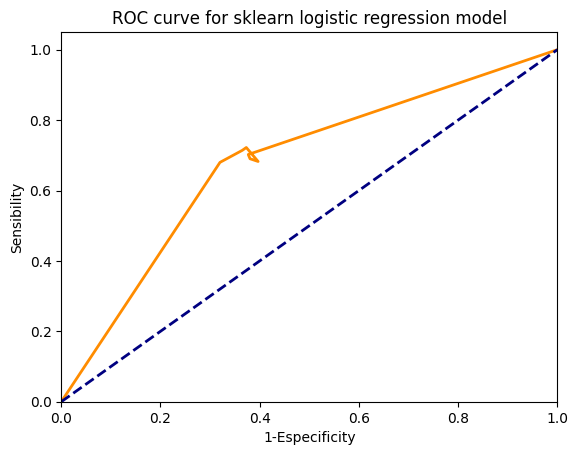

In [45]:
# initial variables
test_percentages = [0.1, 0.25, 0.50, 0.75, 0.9, 1]
y_tests = {'our_model': [], 'sklearn_model': []}
y_preds = {'our_model': [], 'sklearn_model': []}
accurancies = {'our_model': [], 'sklearn_model': []}
precisions = {'our_model': [], 'sklearn_model': []}
recalls = {'our_model': [], 'sklearn_model': []}
num_rows = min(X0_test.shape[0], X1_test.shape[0])

# Get the bes model hyperparameters
model = OurDecisionTreeClassifier()
param_grid = {'max_depth': [5, 6, 7]}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train.values, y_train.values)
print("Best hyperparameters: ", grid_search.best_params_)

# Instantiate model with the best hyperparameters
model = OurDecisionTreeClassifier(max_depth=5)
model.fit(x=X_train.values, y=y_train.values)

# Instantiate sklearn logistic regression model
model_sklearn = DecisionTreeClassifier()


model_sklearn.fit(X_train, y_train.astype('int'))

# get testing metrics by using different amount of tests
for test_percentage in test_percentages:

    # get the amount of data needed for each percentage
    n_tests = int(num_rows * test_percentage)
    X0_test_i = X0_test.iloc[:n_tests, :]
    X1_test_i = X1_test.iloc[:n_tests, :]
    y0_test_i = y0_test.iloc[:n_tests]
    y1_test_i = y1_test.iloc[:n_tests]

    X_test_i = pd.concat([X0_test_i, X1_test_i], axis= 0)
    y_test_i = pd.concat([y0_test_i, y1_test_i], axis= 0)
    y_tests['our_model'].append(y_test_i.values.astype(int))
    y_tests['sklearn_model'].append(y_test_i.values.astype(int))

    # predict classes for test set
    y_pred_i = model.predict(X_test_i.values)
    y_preds['our_model'].append(y_pred_i)

    # get the metrics
    accurancies['our_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['our_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['our_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))

    ## Predictions for sklearn model
    y_pred_i = model_sklearn.predict(X_test_i)
    y_preds['sklearn_model'].append(y_pred_i)

    # get the metrics
    accurancies['sklearn_model'].append(model.accurancy(y_pred_i, y_test_i.values.astype(int)))
    precisions['sklearn_model'].append(model.precision(y_pred_i, y_test_i.values.astype(int)))
    recalls['sklearn_model'].append(model.recall(y_pred_i, y_test_i.values.astype(int)))


# draw ROC curve
fpr_model = np.array([0., 1.])
tpr_model = np.array([0., 1.])
fpr_sk = np.array([0., 1.])
tpr_sk = np.array([0., 1.])
aucs = {'our_model': [], 'sklearn_model': []}
for i in range(len(test_percentages)):
    fpr_i, tpr_i, auc_i = model.auc(y_preds['sklearn_model'][i], y_tests['sklearn_model'][i])
    fpr_sk = np.insert(fpr_sk, -1, fpr_i[1])
    tpr_sk = np.insert(tpr_sk, -1, tpr_i[1])
    aucs['sklearn_model'].append(auc_i)

    fpr_i, tpr_i, auc_i = model.auc(y_preds['our_model'][i], y_tests['our_model'][i])
    fpr_model = np.insert(fpr_model, -1, fpr_i[1])
    tpr_model = np.insert(tpr_model, -1, tpr_i[1])
    aucs['our_model'].append(auc_i)

    

# display test metric results
title_row = ['Amount of tests','Model', 'Accurancy', 'Precision', 'Recall', 'Auc']
df_results = pd.DataFrame(columns=title_row)

for i, test_percentage in enumerate(test_percentages):
    row = [int(test_percentage*num_rows), 'Our model', accurancies['our_model'][i], precisions['our_model'][i], recalls['our_model'][i], aucs['our_model'][i]]
    df_results.loc[len(df_results)] = row
    row = [int(test_percentage*num_rows), 'Sklearn model', accurancies['sklearn_model'][i], precisions['sklearn_model'][i], recalls['sklearn_model'][i], aucs['sklearn_model'][i]]
    df_results.loc[len(df_results)] = row

print(df_results)
model.plot_roc(fpr_model, tpr_model, 'ROC curve for our logistic regression model')
model.plot_roc(fpr_sk, tpr_sk, 'ROC curve for sklearn logistic regression model')